In [ ]:
!pip install matplotlib

加载数据文件...
成功加载数据，共有 1694 个数据集。
创建对比图...


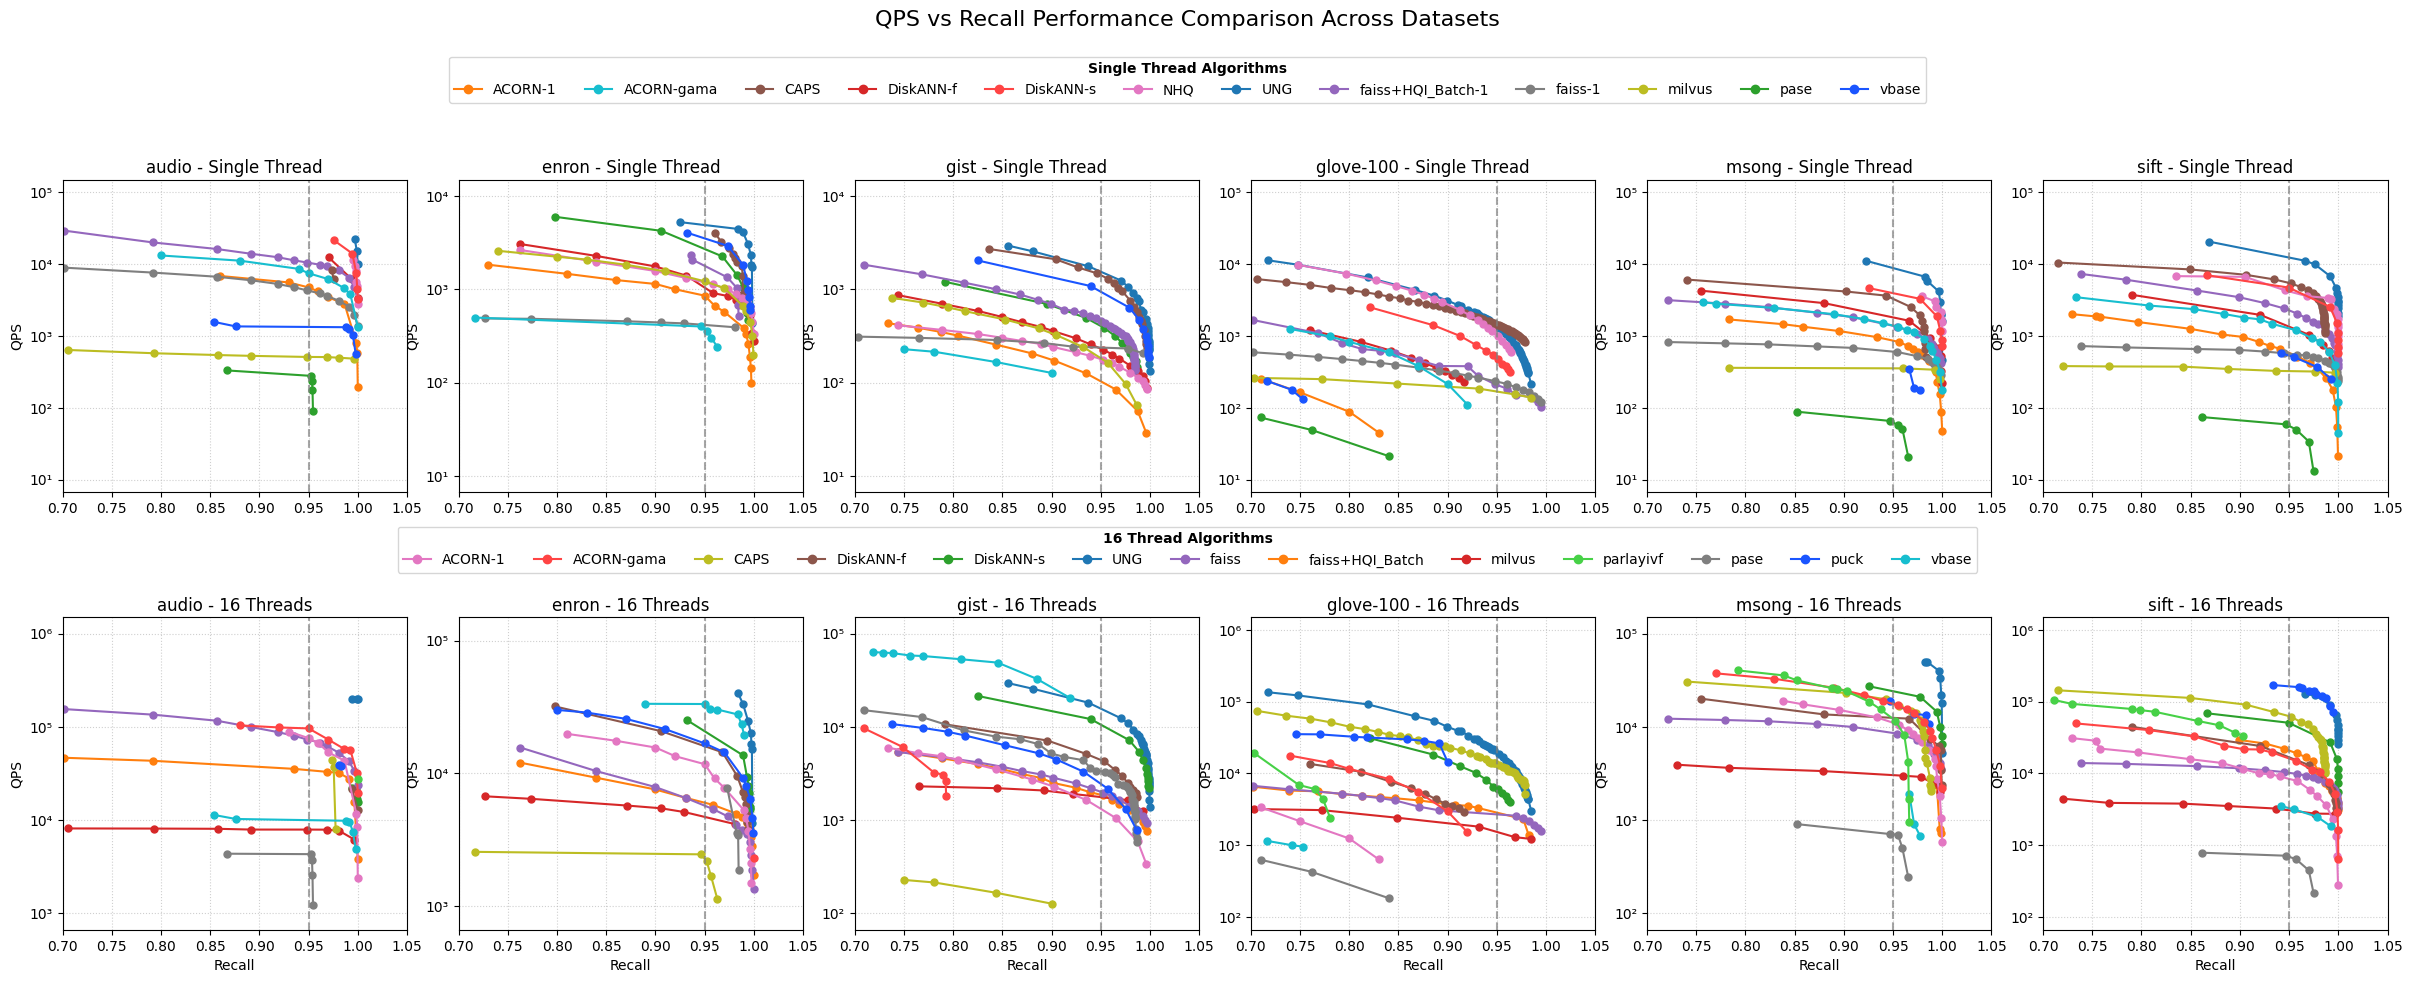

图表已创建并保存！


In [5]:
import os
import pandas as pd
import numpy as np
import glob
import re
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import warnings

warnings.filterwarnings("ignore")

# 定义数据路径
data_path = "/data/result"  # 请修改为实际路径

# 基础颜色列表
colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#1a55FF', '#FF4444', '#47D147', '#AA44FF', '#FF9933'
]

# 将算法分组（单线程和16线程）
def group_algorithms(algorithms):
    alg_16Thread = []
    alg_other = []
    for alg in algorithms:
        if alg.endswith('-16'):
            alg_16Thread.append(alg)
        else:
            alg_other.append(alg)
    return alg_16Thread, alg_other

# 获取所有结果文件
def get_all_result_files():
    result_files = []
    algorithm_dirs = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    
    for alg in algorithm_dirs:
        alg_result_path = os.path.join(data_path, alg, "result")
        if os.path.exists(alg_result_path):
            files = glob.glob(os.path.join(alg_result_path, "*_results.csv"))
            for file in files:
                result_files.append((file, alg))
    
    return result_files

# 提取数据集名称和查询集编号
def extract_file_info(filename, algorithm):
    base = os.path.basename(filename)
    match = re.match(r'(.+?)_(\d+(?:_\d+)?)_results\.csv', base)
    if match:
        dataset = match.group(1)
        queryset = match.group(2)
        return dataset, queryset, algorithm
    return None, None, None

# 加载所有数据
def load_all_data():
    all_data = {}
    files_with_algs = get_all_result_files()
    
    for file, algorithm in files_with_algs:
        dataset, queryset, algorithm = extract_file_info(file, algorithm)
        if dataset and queryset and algorithm:
            try:
                df = pd.read_csv(file)
                
                if 'Recall' not in df.columns or 'QPS' not in df.columns:
                    print(f"Warning: File {file} missing required columns. Skipping.")
                    continue
                
                df['Algorithm'] = algorithm
                
                key = (dataset, queryset)
                if key not in all_data:
                    all_data[key] = []
                all_data[key].append(df)
                
            except Exception as e:
                print(f"Error loading {file}: {e}")
    
    return all_data

# 计算帕累托前沿
def compute_pareto_frontier(df, x_col, y_col):
    if df.empty:
        return pd.DataFrame()
    
    x = df[x_col].values
    y = df[y_col].values
    
    sorted_indices = sorted(range(len(y)), key=lambda k: -y[k])
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]
    
    pareto_front_x = [x_sorted[0]]
    pareto_front_y = [y_sorted[0]]
    
    for i in range(1, len(x_sorted)):
        if x_sorted[i] > pareto_front_x[-1]:
            pareto_front_x.append(x_sorted[i])
            pareto_front_y.append(y_sorted[i])
    
    indices = []
    for px, py in zip(pareto_front_x, pareto_front_y):
        matches = df[(df[x_col] == px) & (df[y_col] == py)].index
        if not matches.empty:
            indices.append(matches[0])
    
    if indices:
        return df.loc[indices].sort_values(by=x_col, ascending=True)
    else:
        return pd.DataFrame()

# 获取y轴范围和刻度
def get_y_range_and_ticks(y_data_list):
    if not y_data_list:
        return 10**2, 10**5, [10**2, 10**3, 10**4, 10**5], ["10²", "10³", "10⁴", "10⁵"]
    
    # 获取所有数据的最小值和最大值
    all_y_values = [y for sublist in y_data_list for y in sublist]
    
    if not all_y_values:
        return 10**2, 10**5, [10**2, 10**3, 10**4, 10**5], ["10²", "10³", "10⁴", "10⁵"]
    
    min_y = min(all_y_values)
    max_y = max(all_y_values)
    
    # 确定最小和最大的幂次
    min_power = max(0, np.floor(np.log10(min_y)))
    max_power = np.ceil(np.log10(max_y))
    
    # 确保至少有2个主刻度
    if max_power - min_power < 1:
        min_power = max(0, max_power - 2)
    
    # 设置y轴范围，稍微扩展一点
    y_min = 10 ** min_power / 1.5
    y_max = 10 ** max_power * 1.5
    
    # 生成刻度值和标签
    ticks = [10 ** i for i in range(int(min_power), int(max_power) + 1)]
    tick_labels = [f"10{superscript(i)}" for i in range(int(min_power), int(max_power) + 1)]
    
    return y_min, y_max, ticks, tick_labels

# 辅助函数：将数字转换为上标
def superscript(n):
    superscript_map = {
        '0': '⁰', '1': '¹', '2': '²', '3': '³', '4': '⁴',
        '5': '⁵', '6': '⁶', '7': '⁷', '8': '⁸', '9': '⁹',
        '-': '⁻'
    }
    return ''.join(superscript_map[digit] for digit in str(n))

# 绘制所有数据集的QPS vs Recall对比图
def plot_all_datasets_comparison(all_data):
    query_set = "1"  # 这里假设我们只关心查询集1
    datasets = sorted(set(k[0] for k in all_data.keys() if k[1] == query_set))
    
    # 如果数据集少于6个，补充到6个
    if len(datasets) < 6:
        datasets = datasets + [None] * (6 - len(datasets))
    # 如果数据集多于6个，只取前6个
    elif len(datasets) > 6:
        datasets = datasets[:6]
    
    # 创建一个2行6列的大图，使用更宽的比例
    fig = plt.figure(figsize=(30, 10))
    
    # 调整上下间距，给图例留出空间
    gs = GridSpec(2, 6, figure=fig, wspace=0.15, hspace=0.4, height_ratios=[1, 1], top=0.85, bottom=0.1)
    
    # 收集所有算法名称用于后续绘制图例
    all_single_thread_algs = {}  # 使用字典存储算法名和对应的颜色
    all_16_thread_algs = {}
    
    # 遍历所有数据集，绘制单线程和16线程的图
    for col, dataset in enumerate(datasets):
        if dataset is None:
            continue
        
        key = (dataset, query_set)
        if key not in all_data:
            continue
        
        data_list = all_data[key]
        all_algorithms = set(df['Algorithm'].iloc[0] for df in data_list if 'Algorithm' in df.columns)
        alg_16Thread, alg_single = group_algorithms(all_algorithms)
        
        # 绘制单线程图 (第一行)
        ax_single = fig.add_subplot(gs[0, col])
        
        # 收集单线程图的Y轴数据，为每个算法单独收集
        single_thread_y_data = []
        
        # 绘制单线程算法数据
        for i, df in enumerate([d for d in data_list if d['Algorithm'].iloc[0] in alg_single]):
            algorithm = df['Algorithm'].iloc[0]
            color_idx = i % len(colors)
            color = colors[color_idx]
            
            # 保存算法和对应的颜色
            if algorithm not in all_single_thread_algs:
                all_single_thread_algs[algorithm] = color
                
            pareto_df = compute_pareto_frontier(df, 'Recall', 'QPS')
            
            if not pareto_df.empty:
                filtered_df = pareto_df[pareto_df['Recall'] >= 0.7]
                if not filtered_df.empty:
                    x_data = filtered_df['Recall'].tolist()
                    y_data = filtered_df['QPS'].tolist()
                    single_thread_y_data.append(y_data)
                    ax_single.plot(x_data, y_data, 'o-', label=algorithm, color=color, markersize=5)
        
        # 设置单线程图的y轴范围和刻度
        y_min_single, y_max_single, y_ticks_single, y_tick_labels_single = get_y_range_and_ticks(single_thread_y_data)
        
        # 设置y轴为对数刻度并调整范围
        ax_single.set_yscale('log')
        ax_single.set_ylim(y_min_single, y_max_single)
        
        # 只显示主刻度
        ax_single.yaxis.set_major_locator(plt.FixedLocator(y_ticks_single))
        ax_single.yaxis.set_minor_locator(plt.NullLocator())
        ax_single.set_yticklabels(y_tick_labels_single)
        
        # 设置x轴范围
        ax_single.set_xlim(0.7, 1.05)
        
        # 参考线和网格
        ax_single.axvline(x=0.95, color='gray', linestyle='--', alpha=0.7)
        ax_single.grid(True, linestyle=':', alpha=0.6)
        
        # 设置标题和标签
        ax_single.set_title(f"{dataset} - Single Thread", fontsize=12, pad=5)
        
        # 仅底部图显示x轴标签
        ax_single.set_xlabel("")
        
        # 所有列都显示y轴标签
        ax_single.set_ylabel("QPS", fontsize=10)
        
        # 绘制16线程图 (第二行)
        ax_16 = fig.add_subplot(gs[1, col])
        
        # 收集16线程图的Y轴数据，为每个算法单独收集
        thread_16_y_data = []
        
        # 绘制16线程算法数据
        for i, df in enumerate([d for d in data_list if d['Algorithm'].iloc[0] in alg_16Thread]):
            algorithm = df['Algorithm'].iloc[0]
            short_name = algorithm.replace('-16', '')
            color_idx = i % len(colors)
            color = colors[color_idx]
            
            # 保存算法和对应的颜色
            if short_name not in all_16_thread_algs:
                all_16_thread_algs[short_name] = color
                
            pareto_df = compute_pareto_frontier(df, 'Recall', 'QPS')
            
            if not pareto_df.empty:
                filtered_df = pareto_df[pareto_df['Recall'] >= 0.7]
                if not filtered_df.empty:
                    x_data = filtered_df['Recall'].tolist()
                    y_data = filtered_df['QPS'].tolist()
                    thread_16_y_data.append(y_data)
                    ax_16.plot(x_data, y_data, 'o-', label=short_name, color=color, markersize=5)
        
        # 设置16线程图的y轴范围和刻度
        y_min_16, y_max_16, y_ticks_16, y_tick_labels_16 = get_y_range_and_ticks(thread_16_y_data)
        
        # 设置y轴为对数刻度并调整范围
        ax_16.set_yscale('log')
        ax_16.set_ylim(y_min_16, y_max_16)
        
        # 只显示主刻度
        ax_16.yaxis.set_major_locator(plt.FixedLocator(y_ticks_16))
        ax_16.yaxis.set_minor_locator(plt.NullLocator())
        ax_16.set_yticklabels(y_tick_labels_16)
        
        # 设置x轴范围
        ax_16.set_xlim(0.7, 1.05)
        
        # 参考线和网格
        ax_16.axvline(x=0.95, color='gray', linestyle='--', alpha=0.7)
        ax_16.grid(True, linestyle=':', alpha=0.6)
        
        # 设置标题和标签
        ax_16.set_title(f"{dataset} - 16 Threads", fontsize=12, pad=5)
        ax_16.set_xlabel("Recall", fontsize=10)
        
        # 所有列都显示y轴标签
        ax_16.set_ylabel("QPS", fontsize=10)
    
    # 添加水平图例
    # 单线程图例
    legend_elements_single = []
    for i, (alg, color) in enumerate(sorted(all_single_thread_algs.items())):
        legend_elements_single.append(plt.Line2D([0], [0], color=color, marker='o', linestyle='-', 
                                               markersize=6, label=alg))
    
    # 16线程图例
    legend_elements_16 = []
    for i, (alg, color) in enumerate(sorted(all_16_thread_algs.items())):
        legend_elements_16.append(plt.Line2D([0], [0], color=color, marker='o', linestyle='-', 
                                           markersize=6, label=alg))
    
    # 添加单线程图例 - 在第一行图表的上方
    if legend_elements_single:
        leg1 = fig.legend(handles=legend_elements_single, 
                        loc='upper center', 
                        bbox_to_anchor=(0.5, 0.98),
                        ncol=min(15, len(legend_elements_single)),
                        fontsize=10,
                        frameon=True,
                        title="Single Thread Algorithms")
        leg1.get_title().set_fontweight('bold')
    
    # 添加16线程图例 - 在第二行图表的上方
    if legend_elements_16:
        leg2 = fig.legend(handles=legend_elements_16, 
                        loc='upper center', 
                        bbox_to_anchor=(0.5, 0.51),
                        ncol=min(15, len(legend_elements_16)),
                        fontsize=10,
                        frameon=True,
                        title="16 Thread Algorithms")
        leg2.get_title().set_fontweight('bold')
    
    # 设置整体标题
    plt.suptitle("QPS vs Recall Performance Comparison Across Datasets", fontsize=16, y=1.02)
    
    # 调整布局
    plt.tight_layout(rect=[0, 0.0, 1, 1.0])
    
    return fig

# 在Jupyter环境中使用的代码

# 加载数据
print("加载数据文件...")
all_data = load_all_data()

if not all_data:
    print("未找到有效的数据文件，请检查路径和文件格式。")
else:
    print(f"成功加载数据，共有 {sum(len(data_list) for data_list in all_data.values())} 个数据集。")
    
    # 创建对比图
    print("创建对比图...")
    fig = plot_all_datasets_comparison(all_data)
    
    # 保存图表
    plt.savefig("算法性能对比图.png", dpi=300, bbox_inches='tight')
    
    # 显示图表
    plt.show()
    
    print("图表已创建并保存！")

## 下面的代码是绘制可交互图像的代码

In [ ]:
import os
import pandas as pd
import numpy as np
import glob
import re
import colorsys
from pyecharts import options as opts
from pyecharts.charts import Line, Page
from pyecharts.commons.utils import JsCode
import warnings

warnings.filterwarnings("ignore")

# 定义数据路径
data_path = "/data/result"

# 预定义一组美观且具有高对比度的基础颜色
BASE_COLORS = [
    '#1f77b4',  # 蓝色
    '#ff7f0e',  # 橙色
    '#2ca02c',  # 绿色
    '#d62728',  # 红色
    '#9467bd',  # 紫色
    '#8c564b',  # 棕色
    '#e377c2',  # 粉色
    '#7f7f7f',  # 灰色
    '#bcbd22',  # 黄绿色
    '#17becf',  # 青色
    '#1a55FF',  # 亮蓝色
    '#FF4444',  # 亮红色
    '#47D147',  # 亮绿色
    '#AA44FF',  # 亮紫色
    '#FF9933',  # 亮橙色
    '#33CCFF',  # 天蓝色
]

def generate_distinct_colors(n):
    """
    生成n个具有高对比度的不同颜色
    
    策略：
    1. 首先使用预定义的基础颜色
    2. 如果需要更多颜色，则通过调整色相、饱和度和明度生成
    3. 确保相邻颜色有足够的区分度
    """
    colors = BASE_COLORS.copy()
    
    if n <= len(colors):
        return colors[:n]
    
    # 需要生成额外的颜色
    additional_colors_needed = n - len(colors)
    
    # 使用黄金分割比来生成分散的色相值
    golden_ratio = 0.618033988749895
    hue = 0.
    
    for i in range(additional_colors_needed):
        hue = (hue + golden_ratio) % 1.0
        # 使用较高的饱和度和明度以确保颜色鲜艳
        saturation = 0.7 + (i % 3) * 0.1  # 在0.7-0.9之间变化
        value = 0.8 + (i % 2) * 0.1       # 在0.8-0.9之间变化
        
        rgb = colorsys.hsv_to_rgb(hue, saturation, value)
        # 转换为16进制颜色代码
        hex_color = '#{:02x}{:02x}{:02x}'.format(
            int(rgb[0] * 255),
            int(rgb[1] * 255),
            int(rgb[2] * 255)
        )
        colors.append(hex_color)
    
    return colors

# 生成100个不同的颜色
colors = generate_distinct_colors(100)

# 将算法分组（单线程和16线程）
def group_algorithms(algorithms):
    alg_16Thread = []
    alg_other = []
    for alg in algorithms:
        if alg.endswith('-16'):
            alg_16Thread.append(alg)
        else:
            alg_other.append(alg)
    return alg_16Thread, alg_other

# 获取所有结果文件
def get_all_result_files():
    # 新路径格式为 /data/result/{算法名}/result/{数据集名}_{查询集编号}_results.csv
    result_files = []
    # 获取所有算法目录
    algorithm_dirs = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    
    for alg in algorithm_dirs:
        # 构建算法的result目录路径
        alg_result_path = os.path.join(data_path, alg, "result")
        if os.path.exists(alg_result_path):
            # 获取该算法下的所有结果文件
            files = glob.glob(os.path.join(alg_result_path, "*_results.csv"))
            for file in files:
                result_files.append((file, alg))
    
    return result_files

# 提取数据集名称和查询集编号
def extract_file_info(filename, algorithm):
    base = os.path.basename(filename)
    match = re.match(r'(.+?)_(\d+(?:_\d+)?)_results\.csv', base)
    if match:
        dataset = match.group(1)
        queryset = match.group(2)
        return dataset, queryset, algorithm
    return None, None, None

# 加载所有数据
def load_all_data():
    all_data = {}
    files_with_algs = get_all_result_files()
    
    for file, algorithm in files_with_algs:
        dataset, queryset, algorithm = extract_file_info(file, algorithm)
        if dataset and queryset and algorithm:
            try:
                df = pd.read_csv(file)
                
                # 检查必要的列是否存在（至少需要Recall和QPS列）
                required_columns = ['Recall', 'QPS']
                if not all(col in df.columns for col in required_columns):
                    print(f"Warning: File {file} missing required columns. Skipping.")
                    continue
                
                # 添加算法名列
                df['Algorithm'] = algorithm
                
                key = (dataset, queryset)
                if key not in all_data:
                    all_data[key] = []
                all_data[key].append(df)
                
            except Exception as e:
                print(f"Error loading {file}: {e}")
    
    return all_data

# 计算帕累托前沿
def compute_pareto_frontier(df, x_col, y_col, maximize_x=True, maximize_y=True):
    """
    计算帕累托前沿
    
    参数:
    df (DataFrame): 包含数据的DataFrame
    x_col (str): x轴的列名
    y_col (str): y轴的列名
    maximize_x (bool): 是否最大化x
    maximize_y (bool): 是否最大化y
    
    返回:
    DataFrame: 帕累托前沿点的DataFrame
    """
    if df.empty:
        return pd.DataFrame()
    
    # 获取x和y的numpy数组
    x = df[x_col].values
    y = df[y_col].values
    
    # 对于QPS vs Recall，我们希望y (QPS)越高越好，所以要排序时考虑-y
    sorted_indices = sorted(range(len(y)), key=lambda k: -y[k])
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]
    
    pareto_front_x = [x_sorted[0]]
    pareto_front_y = [y_sorted[0]]
    
    for i in range(1, len(x_sorted)):
        if x_sorted[i] > pareto_front_x[-1]:
            pareto_front_x.append(x_sorted[i])
            pareto_front_y.append(y_sorted[i])
    
    # 创建帕累托前沿的DataFrame
    indices = []
    for px, py in zip(pareto_front_x, pareto_front_y):
        # 找到原始DataFrame中与当前点匹配的行
        matches = df[(df[x_col] == px) & (df[y_col] == py)].index
        if not matches.empty:
            indices.append(matches[0])
    
    # 返回帕累托前沿点的DataFrame
    if indices:
        return df.loc[indices].sort_values(by=x_col, ascending=True)
    else:
        return pd.DataFrame()

# 使用pyecharts绘制QPS vs Recall图（使用帕累托前沿）
def plot_qps_vs_recall(data_list, title, save_path, width="900px", height="600px"):
    # 获取所有算法
    all_algorithms = set()
    for df in data_list:
        if 'Algorithm' in df.columns:
            all_algorithms.add(df['Algorithm'].iloc[0])
    
    # 分组算法
    alg_16Thread, alg_other = group_algorithms(all_algorithms)
    
    # 创建一个标记线显示0.95的recall线
    mark_line_opts = opts.MarkLineOpts(
        data=[
            opts.MarkLineItem(xcoord=0.95, name="Recall 0.95"),
        ],
        label_opts=opts.LabelOpts(
            position="middle",
            formatter="{b}",
            font_style="italic",
            font_weight="bold",
            font_size=12,
        ),
        linestyle_opts=opts.LineStyleOpts(
            type_="dashed",
            color="#777",
            width=1.5,
        ),
    )
    
    # 如果两组都有算法，则绘制两张图
    if alg_16Thread and alg_other:
        # 绘制16位算法图
        line_16Thread = (
            Line(init_opts=opts.InitOpts(width=width, height=height))
            .set_global_opts(
                title_opts=opts.TitleOpts(title=f"{title} (16-bit algorithms)"),
                tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="cross"),
                xaxis_opts=opts.AxisOpts(
                    type_="value", 
                    name="Recall",
                    name_location="center",
                    name_gap=35,
                    min_=0.7,
                    max_=1.05,
                ),
                yaxis_opts=opts.AxisOpts(
                    type_="log", 
                    name="QPS",
                    name_location="center",
                    name_gap=35,
                    axislabel_opts=opts.LabelOpts(formatter="{value}"),
                    splitline_opts=opts.SplitLineOpts(is_show=False),  # 隐藏次刻度线
                    minor_tick_opts=opts.AxisTickOpts(is_show=False),  # 隐藏次刻度
                ),
                legend_opts=opts.LegendOpts(
                    orient="vertical", 
                    pos_right="0%", 
                    pos_top="10%",
                    border_width=1,
                    border_color="#ccc",
                    padding=10,
                    item_gap=10,
                    item_width=25,
                    item_height=14,
                    background_color="rgba(255,255,255,0.8)",  # 半透明背景
                ),
                datazoom_opts=[
                    opts.DataZoomOpts(range_start=0, range_end=100),
                    opts.DataZoomOpts(type_="inside", range_start=0, range_end=100),
                ],
            )
        )
        
        # 添加横线
        line_16Thread.set_series_opts(markline_opts=mark_line_opts)
        
        for i, df in enumerate([d for d in data_list if d['Algorithm'].iloc[0] in alg_16Thread]):
            algorithm = df['Algorithm'].iloc[0]
            pareto_df = compute_pareto_frontier(df, 'Recall', 'QPS', maximize_x=True, maximize_y=True)
            
            if not pareto_df.empty:
                # 过滤掉小于0.7的recall点
                filtered_df = pareto_df[pareto_df['Recall'] >= 0.7]
                if not filtered_df.empty:
                    x_data = filtered_df['Recall'].tolist()
                    y_data = filtered_df['QPS'].tolist()
                    
                    line_16Thread.add_xaxis(x_data)
                    line_16Thread.add_yaxis(
                        series_name=algorithm,
                        y_axis=y_data,
                        symbol_size=8,
                        label_opts=opts.LabelOpts(is_show=False),
                        linestyle_opts=opts.LineStyleOpts(width=2),
                        itemstyle_opts=opts.ItemStyleOpts(color=colors[i % len(colors)]),
                    )
        
        # 保存16位算法图
        save_path_16 = save_path.replace('.html', '16Thread.html')
        os.makedirs(os.path.dirname(save_path_16), exist_ok=True)
        line_16Thread.render(save_path_16)
        
        # 绘制其他算法图
        line_other = (
            Line(init_opts=opts.InitOpts(width=width, height=height))
            .set_global_opts(
                title_opts=opts.TitleOpts(title=f"{title} (other algorithms)"),
                tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="cross"),
                xaxis_opts=opts.AxisOpts(
                    type_="value", 
                    name="Recall",
                    name_location="center",
                    name_gap=35,
                    min_=0.7,
                    max_=1.05,
                ),
                yaxis_opts=opts.AxisOpts(
                    type_="log", 
                    name="QPS",
                    name_location="center",
                    name_gap=35,
                    axislabel_opts=opts.LabelOpts(formatter="{value}"),
                    splitline_opts=opts.SplitLineOpts(is_show=False),  # 隐藏次刻度线
                    minor_tick_opts=opts.AxisTickOpts(is_show=False),  # 隐藏次刻度
                ),
                legend_opts=opts.LegendOpts(
                    orient="vertical", 
                    pos_right="0%", 
                    pos_top="10%",
                    border_width=1,
                    border_color="#ccc",
                    padding=10,
                    item_gap=10,
                    item_width=25,
                    item_height=14,
                    background_color="rgba(255,255,255,0.8)",  # 半透明背景
                ),
                datazoom_opts=[
                    opts.DataZoomOpts(range_start=0, range_end=100),
                    opts.DataZoomOpts(type_="inside", range_start=0, range_end=100),
                ],
            )
        )
        
        # 添加横线
        line_other.set_series_opts(markline_opts=mark_line_opts)
        
        for i, df in enumerate([d for d in data_list if d['Algorithm'].iloc[0] in alg_other]):
            algorithm = df['Algorithm'].iloc[0]
            pareto_df = compute_pareto_frontier(df, 'Recall', 'QPS', maximize_x=True, maximize_y=True)
            
            if not pareto_df.empty:
                # 过滤掉小于0.7的recall点
                filtered_df = pareto_df[pareto_df['Recall'] >= 0.7]
                if not filtered_df.empty:
                    x_data = filtered_df['Recall'].tolist()
                    y_data = filtered_df['QPS'].tolist()
                    
                    line_other.add_xaxis(x_data)
                    line_other.add_yaxis(
                        series_name=algorithm,
                        y_axis=y_data,
                        symbol_size=8,
                        label_opts=opts.LabelOpts(is_show=False),
                        linestyle_opts=opts.LineStyleOpts(width=2),
                        itemstyle_opts=opts.ItemStyleOpts(color=colors[i % len(colors)]),
                    )
        
        # 保存其他算法图
        save_path_other = save_path.replace('.html', '_other.html')
        os.makedirs(os.path.dirname(save_path_other), exist_ok=True)
        line_other.render(save_path_other)
    
    else:
        # 如果只有一组算法，则绘制单张图
        line = (
            Line(init_opts=opts.InitOpts(width=width, height=height))
            .set_global_opts(
                title_opts=opts.TitleOpts(title=title),
                tooltip_opts=opts.TooltipOpts(trigger="axis", axis_pointer_type="cross"),
                xaxis_opts=opts.AxisOpts(
                    type_="value", 
                    name="Recall",
                    name_location="center",
                    name_gap=35,
                    min_=0.7,
                    max_=1.05,
                ),
                yaxis_opts=opts.AxisOpts(
                    type_="log", 
                    name="QPS",
                    name_location="center",
                    name_gap=35,
                    axislabel_opts=opts.LabelOpts(formatter="{value}"),
                    splitline_opts=opts.SplitLineOpts(is_show=False),  # 隐藏次刻度线
                    minor_tick_opts=opts.AxisTickOpts(is_show=False),  # 隐藏次刻度
                ),
                legend_opts=opts.LegendOpts(
                    orient="vertical", 
                    pos_right="0%", 
                    pos_top="10%",
                    border_width=1,
                    border_color="#ccc",
                    padding=10,
                    item_gap=10,
                    item_width=25,
                    item_height=14,
                    background_color="rgba(255,255,255,0.8)",  # 半透明背景
                ),
                datazoom_opts=[
                    opts.DataZoomOpts(range_start=0, range_end=100),
                    opts.DataZoomOpts(type_="inside", range_start=0, range_end=100),
                ],
            )
        )
        
        # 添加横线
        line.set_series_opts(markline_opts=mark_line_opts)
        
        for i, df in enumerate(data_list):
            algorithm = df['Algorithm'].iloc[0]
            pareto_df = compute_pareto_frontier(df, 'Recall', 'QPS', maximize_x=True, maximize_y=True)
            
            if not pareto_df.empty:
                # 过滤掉小于0.7的recall点
                filtered_df = pareto_df[pareto_df['Recall'] >= 0.7]
                if not filtered_df.empty:
                    x_data = filtered_df['Recall'].tolist()
                    y_data = filtered_df['QPS'].tolist()
                    
                    line.add_xaxis(x_data)
                    line.add_yaxis(
                        series_name=algorithm,
                        y_axis=y_data,
                        symbol_size=8,
                        label_opts=opts.LabelOpts(is_show=False),
                        linestyle_opts=opts.LineStyleOpts(width=2),
                        itemstyle_opts=opts.ItemStyleOpts(color=colors[i % len(colors)]),
                    )
        
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        line.render(save_path)

# 创建输出目录
def create_output_dirs():
    dirs = [
        "plots_one/1_single_label",
       
    ]
    
    for d in dirs:
        os.makedirs(d, exist_ok=True)
    
    return dirs


# 1. 简单单标签搜索实验比较
def plot_single_label_search(all_data, output_dir):
    query_set = "1"
    
    # 对每个数据集，将不同算法的结果绘制在同一图中
    for dataset in set(k[0] for k in all_data.keys()):
        key = (dataset, query_set)
        if key in all_data:
            title = f"{dataset} - Comparison of different algorithms for single label search - query set {query_set}"
            save_path = os.path.join(output_dir, f"{dataset}_queryset_{query_set}_algorithms_comparison.html")
            plot_qps_vs_recall(all_data[key], title, save_path)
def main():
    # 创建输出目录
    output_dirs = create_output_dirs()
    
    # 加载所有数据
    print("加载数据文件...")
    all_data = load_all_data()
    
    if not all_data:
        print("未找到有效的数据文件，请检查路径和文件格式。")
        return
    
    print(f"成功加载数据，共有 {sum(len(data_list) for data_list in all_data.values())} 个数据集。")
    
    # 运行各个实验的图表绘制
    print("1. 绘制简单单标签搜索实验比较图...")
    plot_single_label_search(all_data, output_dirs[0])
    

   
    
    print("所有图表绘制完成！")
if __name__ == "__main__":
    main()